In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize
import scipy.constants as cs
import pandas as pd
from utils import *

In [3]:
name = 'dati_MFPT/20-01-10/qpd_Ttrap50ms_Ttot200ms_'
N = (240,1000)
fps = 50000
std_calib = 0.03344148949490509
creneau_inv = 1
fit_diffus_t_end = 0.02 # choix du domaine de validité de la diffusion libre
y_correction_beg = 20

In [59]:
name = 'dati_MFPT/20-01-10/qpd_Ttrap50ms_Ttot60ms_'
N = (1,230)
fps = 50000
std_calib = 0.03291502041883577
creneau_inv = 1
fit_diffus_t_end = 0.008
y_correction_beg = 2

In [85]:
name = 'dati_MFPT/20-02-24/Ttrap500ms_Ttot1000ms_200fps_ter_'
N = (1,1000)
fps = 50000
std_calib = None
creneau_inv = 1
fit_diffus_t_end = 0.008
y_correction_beg = None

### Chargement des données

In [86]:
def load_data (filename, creneau_inv, fps):
    data = scipy.io.loadmat(filename)['data']
    # sorties de la QPD
    a = data[0][0::5]
    b = data[0][1::5]
    c = data[0][2::5]
    d = data[0][3::5]
    s = a+b+c+d
    # calcul de x et de y à partir des sorties QPD
    x = (a+b-c-d)/s
    y = (a-b-c+d)/s
    # temps
    t = np.arange(x.shape[0])/fps
    # laser de trapping on/off
    creneau = creneau_inv * data[0][4::5]
    thresh = creneau.mean()
    trapped = creneau > thresh # la particule est trapped
    free = np.logical_not(trapped) # la particule est libre
    # indices correspondant au début/fin d'une période de trapping
    i_beg_trapping = np.where(np.logical_and(free[:-1],trapped[1:]))[0]
    i_end_trapping = np.where(np.logical_and(trapped[:-1],free[1:]))[0]
    
    return t,x,y,trapped,free,i_beg_trapping,i_end_trapping

### Exemple de trajectoire

<ipython-input-86-e15f488553cf>:16: RuntimeWarning: Mean of empty slice.
  thresh = creneau.mean()
/usr/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


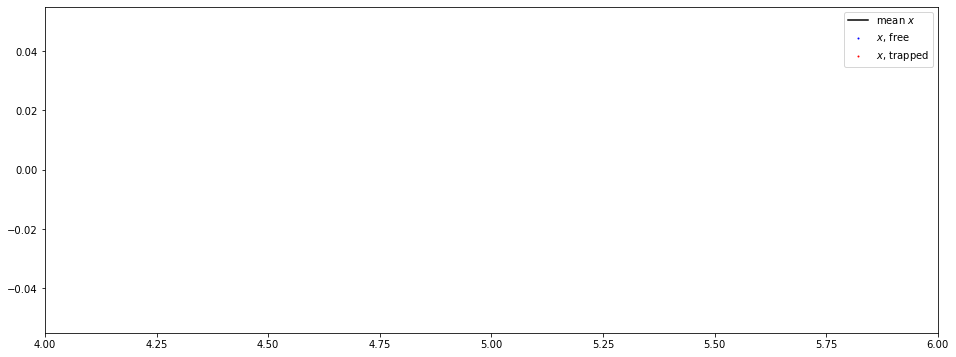

In [87]:
t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(N[1]//2), creneau_inv, fps)
t_trap = t[trapped]
x_trap = x[trapped]
y_trap = y[trapped]
t_free = t[free]
x_free = x[free]
y_free = y[free]

plt.figure(figsize=(16,6))
plt.axhline(y=np.mean(x), color='black', label=r"mean $x$")
plt.scatter(t_free,x_free, color='blue', s=1, label=r"$x$, free")
plt.scatter(t_trap,x_trap, color='red', s=1, label=r"$x$, trapped")
for i in i_end_trapping:
    plt.axvline(x=t[i], linestyle='--', color='blue')
for i in i_beg_trapping:
    plt.axvline(x=t[i], linestyle='--', color='red')
plt.xlim((4,6))
plt.legend(loc='upper right')
plt.savefig(name+"example_traj.pdf")

### Mesure de $\sigma_x$ et $\sigma_y$
en regardant la fin des périodes de trapping

In [23]:
x_end_trapping = []
y_end_trapping = []

length_trap = []
length_free = []

for w in range(N[0],N[1]+1):
    t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(w), creneau_inv, fps)
    
    for i in i_end_trapping:
        x_end_trapping += list(x[i-10:i])
        y_end_trapping += list(y[i-10:i])
    
    k_beg = k_end = 0
    if i_beg_trapping[0] > i_end_trapping[0]:
        k_end = 1
    while k_beg < len(i_beg_trapping)-1 and k_end < len(i_end_trapping):
        assert i_beg_trapping[k_beg] < i_end_trapping[k_end]
        length_trap.append( i_end_trapping[k_end] - i_beg_trapping[k_beg] )
        length_free.append( i_beg_trapping[k_beg+1] - i_end_trapping[k_end] )
        k_beg += 1
        k_end += 1

    print(w, end=' ')

length_trap = np.min(length_trap)
length_free = np.min(length_free)
length_trap,length_free

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

(2499, 500)

Aggrégat de points à la fin des périodes de trapping, de tous les fichiers :

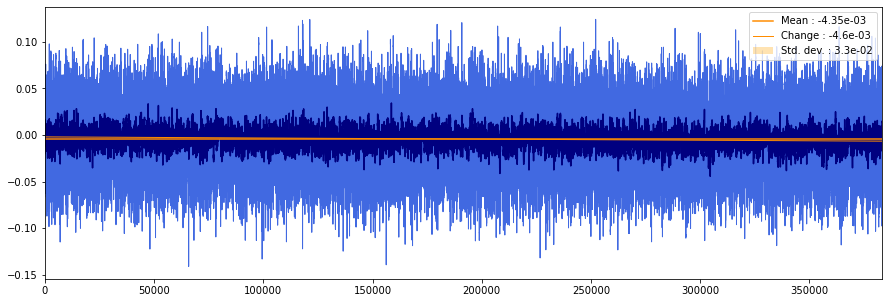

In [24]:
x0,sigma_x,slope = plot_means_synth( np.arange(len(x_end_trapping)), np.array(x_end_trapping), cmak=60 )

Distribution de $x$ en fin de trapping, ajustement sur une gaussienne :

centre en x : -4.35e-03; variance de x_0 : 3.28e-02


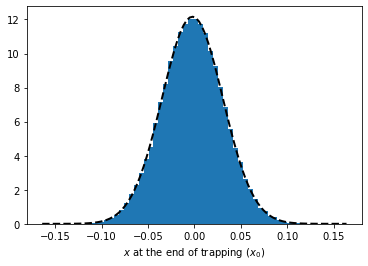

In [25]:
x_end_trapping_detrend = np.array(x_end_trapping) - slope*np.arange(len(x_end_trapping))
_,sigma_x = check_gaussian(x_end_trapping_detrend, bins=50, xlabel=r"$x$ at the end of trapping ($x_0$)")
print("centre en x : {:.2e}; variance de x_0 : {:.2e}".format(x0,sigma_x))

Même chose pour $y$.

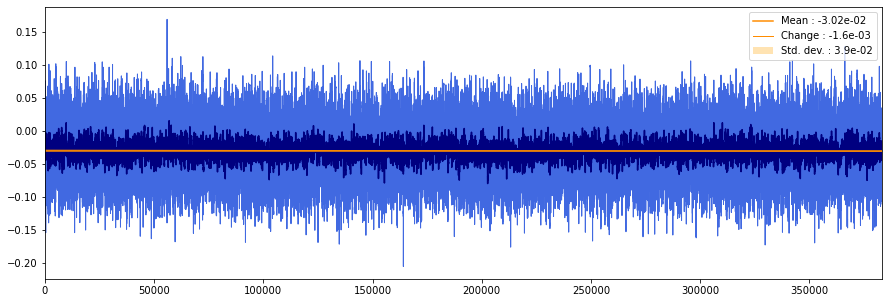

In [26]:
y0,sigma_y,slope = plot_means_synth( np.arange(len(y_end_trapping)), np.array(y_end_trapping), cmak=60 )

centre en y : -3.02e-02; variance de y_0 : 3.87e-02


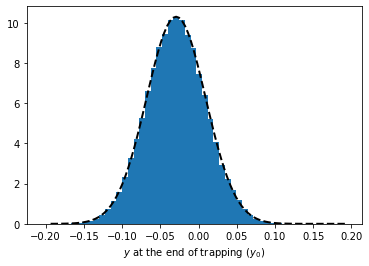

In [27]:
y_end_trapping_detrend = np.array(y_end_trapping) - slope*np.arange(len(y_end_trapping))
_,sigma_y = check_gaussian(y_end_trapping_detrend, bins=50, xlabel=r"$y$ at the end of trapping ($y_0$)")
print("centre en y : {:.2e}; variance de y_0 : {:.2e}".format(y0,sigma_y))

### Courbes moyennes de $x^2$ et $y^2$ sur les périodes de diffusion libre
pour corriger une éventuelle différence d'échelle entre $x$ et $y$

In [28]:
diffus_sn = 30
diffus_t = np.arange(length_free//diffus_sn) / fps * diffus_sn
diffus_x2_acc = [ [] for _ in range(len(diffus_t)) ]
diffus_y2_acc = [ [] for _ in range(len(diffus_t)) ]

for w in range(N[0],N[1]):
    t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(w), creneau_inv, fps)
    
    k_beg = k_end = 0
    if i_beg_trapping[0] > i_end_trapping[0]:
        k_end = 1
    while k_beg < len(i_beg_trapping)-1 and k_end < len(i_end_trapping):
        
        traj_diffus_x = x[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - x0
        traj_diffus_y = y[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - y0
        for k in range(length_free//diffus_sn):
            i = k*diffus_sn
            diffus_x2_acc[k].append(traj_diffus_x[i]**2)
            diffus_y2_acc[k].append(traj_diffus_y[i]**2)
        
        k_beg += 1
        k_end += 1
        
    print(w, end=' ')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

In [29]:
def plot_R2 (t, R2_acc, varname="r", fit_diffus_t_end=None, fit_diffus_sigma0=None, fit_diffus_d=None):
    R2 = np.zeros(len(t))
    R2std = np.zeros(len(t))
    for k in range(len(t)):
        R2[k] = np.mean(R2_acc[k])
        R2std[k] = np.std(R2_acc[k])
    n = len(R2_acc[0])
    plt.figure(figsize=(10,7))
    ax1 = plt.gca()
    ax1.fill_between(t, R2-R2std, R2+R2std, facecolor='orange', alpha=0.3, label=r"$\pm \operatorname{std}("+varname+"^2)$")
    ax1.fill_between(t, R2-R2std/np.sqrt(n), R2+R2std/np.sqrt(n), facecolor='orange', alpha=0.5)
    ax1.plot(t, R2, label=r"$\langle "+varname+r"^2 \rangle_\operatorname{ens}(t)$", lw=2)
    ax1.set_ylim((0,1.1*np.max(R2)))
    ax1.set_xlabel(r"$t$")
    if fit_diffus_t_end is not None:
        k1 = np.searchsorted(t, fit_diffus_t_end)+1
        _coeff, _cov = scipy.optimize.curve_fit( (lambda t,D: D*t), t[:k1]-t[0], R2[:k1]-fit_diffus_sigma0**2, sigma=np.ones(k1) )
        D = _coeff[0]
        D_err = 15*sqrt(np.diag(_cov)[0]) + D*R2std[k1]/R2[k1]/np.sqrt(n)
        ax1.plot(t[:k1], fit_diffus_sigma0**2+D*(t[:k1]-t[0]), '--', color='black', label=r"${}D={:.3f}\pm{:.3f}$".format(2*fit_diffus_d,D,D_err))
        ax1.plot(t[:k1], fit_diffus_sigma0**2+(D+D_err)*(t[:k1]-t[0]), '--', color='grey', lw=1)
        ax1.plot(t[:k1], fit_diffus_sigma0**2+(D-D_err)*(t[:k1]-t[0]), '--', color='grey', lw=1)
        return ax1,R2,R2std,D/(2*fit_diffus_d),D_err/(2*fit_diffus_d)
    return ax1,R2,R2std

fit on 0->0.01 : D_x = 0.1387 ± 4.9%


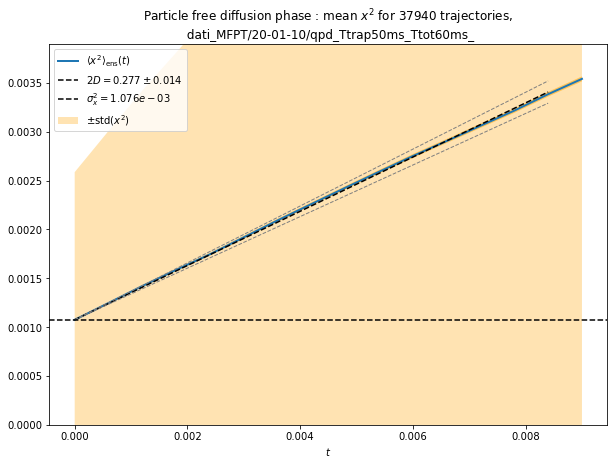

In [53]:
ax,diffus_x2,diffus_x2std,Dx,Dx_err = plot_R2(diffus_t, diffus_x2_acc, "x", fit_diffus_t_end, sigma_x, 1)
print("fit on 0->{:.2f} : D_x = {:.4f} ± {:.1f}%".format(fit_diffus_t_end,Dx,Dx_err/Dx*100))
ax.axhline(y=sigma_x**2, label=r"$\sigma_x^2={:.3e}$".format(sigma_x**2), color='black', linestyle='--')
ax.legend()
plt.title("Particle free diffusion phase : mean $x^2$ for {} trajectories,\n {}".format(len(diffus_x2_acc[0]), name))
plt.savefig(name+"diffus_x2.pdf")

fit on 0->0.01 : D_y_raw = 0.1393 ± 5.0%


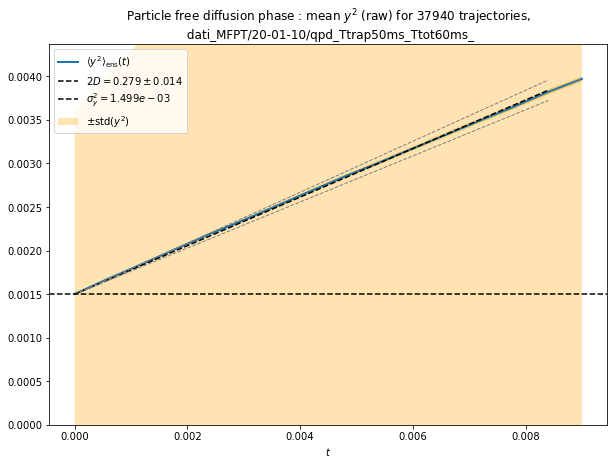

In [54]:
ax,diffus_y2,diffus_y2std,Dy,Dy_err = plot_R2(diffus_t, diffus_y2_acc, "y", fit_diffus_t_end, sigma_y, 1)
print("fit on 0->{:.2f} : D_y_raw = {:.4f} ± {:.1f}%".format(fit_diffus_t_end,Dy,Dy_err/Dy*100))
ax.axhline(y=sigma_y**2, label=r"$\sigma_y^2={:.3e}$".format(sigma_y**2), color='black', linestyle='--')
ax.legend()
plt.title("Particle free diffusion phase : mean $y^2$ (raw) for {} trajectories,\n {}".format(len(diffus_y2_acc[0]), name))
plt.savefig(name+"diffus_y2_raw.pdf")

Correction de l'échelle de $y$ pour que les courbes de diffusion en $x$ et en $y$ coïncident :

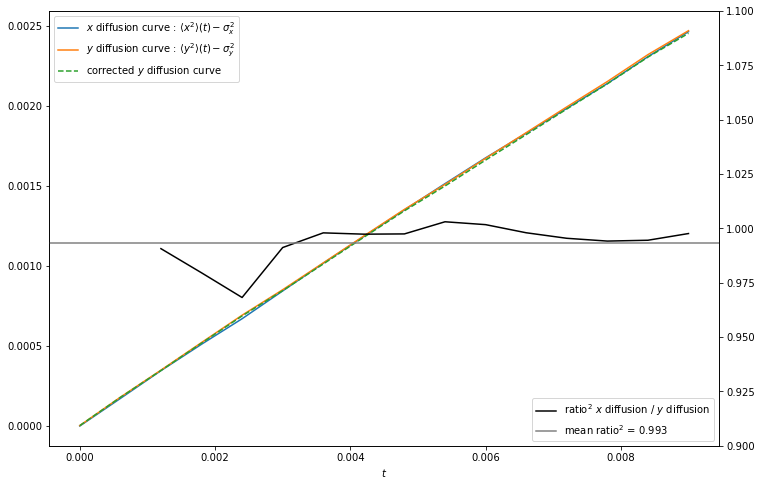

In [60]:
plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax1.plot(diffus_t, diffus_x2-sigma_x**2, label=r"$x$ diffusion curve : $\langle x^2 \rangle(t)-\sigma_x^2$")
ax1.plot(diffus_t, diffus_y2-sigma_y**2, label=r"$y$ diffusion curve : $\langle y^2 \rangle(t)-\sigma_y^2$")

ax2 = ax1.twinx()
ratio_x2_y2 = (diffus_x2-sigma_x**2) / (diffus_y2-sigma_y**2)
ax2.plot( diffus_t[y_correction_beg:], ratio_x2_y2[y_correction_beg:], label=r"ratio$^2$ $x$ diffusion / $y$ diffusion", color='black' )
ratio_x2_y2 = np.mean(ratio_x2_y2[y_correction_beg:])
ax2.axhline(y=ratio_x2_y2, label="mean ratio$^2$ = {:.3f}".format(ratio_x2_y2), color='grey')
ax2.set_ylim((0.9,1.1))

ax1.plot(diffus_t, (diffus_y2-sigma_y**2)*ratio_x2_y2, label=r"corrected $y$ diffusion curve", linestyle='--')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
ax1.set_xlabel(r"$t$")

plt.savefig(name+"correction_y.pdf")

### Courbes moyennes de $r^2$ après correction sur $y$

In [61]:
ratio_x_y = np.sqrt(ratio_x2_y2)
print(ratio_x_y)
sigma_y *= ratio_x_y
print(sigma_x, sigma_y)
sigma = np.sqrt( sigma_x**2 + sigma_y**2 )
print(sigma)

0.9966650977961453
0.032797856671638925 0.038593255965751375
0.050647199412123214


In [62]:
trapped_sn = 20
trapped_t = np.arange(length_trap//trapped_sn) / fps * trapped_sn
trapped_R2_acc = [ [] for _ in range(len(trapped_t)) ]
diffus_sn = 30
diffus_t = np.arange(length_free//diffus_sn) / fps * diffus_sn
diffus_R2_acc = [ [] for _ in range(len(diffus_t)) ]
diffus_mass_center_x = np.zeros(len(diffus_t))
diffus_mass_center_y = np.zeros(len(diffus_t))

i_end_traj = int(fit_diffus_t_end * fps)
file = open(name+"traj_data.bin", "wb")

for w in range(N[0],N[1]):
    t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(w), creneau_inv, fps)
    
    k_beg = k_end = 0
    if i_beg_trapping[0] > i_end_trapping[0]:
        k_end = 1
    while k_beg < len(i_beg_trapping)-1 and k_end < len(i_end_trapping):
        
        traj_trapped_x =   x[ i_beg_trapping[k_beg]:i_end_trapping[k_end] ] - x0
        traj_trapped_y = ( y[ i_beg_trapping[k_beg]:i_end_trapping[k_end] ] - y0 ) * ratio_x_y
        for k in range(length_trap//trapped_sn):
            i = k*trapped_sn
            r2 = traj_trapped_x[i]**2 + traj_trapped_y[i]**2
            trapped_R2_acc[k].append(r2)
        
        traj_diffus_x =   x[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - x0
        traj_diffus_y = ( y[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - y0 ) * ratio_x_y
        for k in range(length_free//diffus_sn):
            i = k*diffus_sn
            r2 = traj_diffus_x[i]**2 + traj_diffus_y[i]**2
            diffus_R2_acc[k].append(r2)
            diffus_mass_center_x[k] += traj_diffus_x[i]
            diffus_mass_center_y[k] += traj_diffus_y[i]
            
        data = np.empty((2*i_end_traj,), dtype=np.float64)
        data[0::2] = traj_diffus_x[:i_end_traj]
        data[1::2] = traj_diffus_y[:i_end_traj]
        data.tofile(file)
        
        k_beg += 1
        k_end += 1
        
    print(w, end=' ')

file.close()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 

$r^2$ moyen pendant la phase de trapping de la particule, juste pour vérifier que le trapping fonctionne bien, qu'il dure suffisemment longtemps, et que la détermination de $\sigma$ est cohérente :

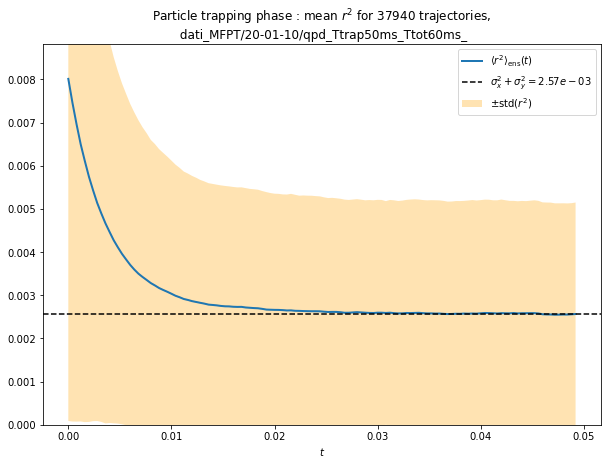

In [63]:
ax,trapped_R2,trapped_R2std = plot_R2(trapped_t, trapped_R2_acc)
ax.axhline(y=sigma**2, label=r"$\sigma_x^2+\sigma_y^2={:.2e}$".format(sigma**2), color='black', linestyle='--')
ax.legend()
plt.title("Particle trapping phase : mean $r^2$ for {} trajectories,\n {}".format(len(trapped_R2_acc[0]), name))
plt.savefig(name+"trapping_r2.pdf")

$r^2$ moyen pendant la phase de diffusion libre, et détermination finale du coefficient de diffusion $D$ sur le domaine de validité choisi :

0.13854946271675095
0.1385494627179348


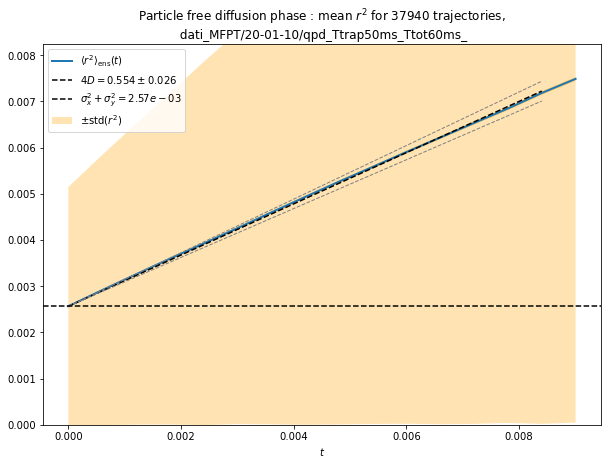

In [64]:
ax,diffus_R2,diffus_R2std,D,D_err = plot_R2(diffus_t, diffus_R2_acc, "r", fit_diffus_t_end, sigma, 2)
ax.axhline(y=sigma**2, label=r"$\sigma_x^2+\sigma_y^2={:.2e}$".format(sigma**2), color='black', linestyle='--')
print(D)
print((Dx + Dy*ratio_x2_y2)/2)
ax.legend()
plt.title("Particle free diffusion phase : mean $r^2$ for {} trajectories,\n {}".format(len(diffus_R2_acc[0]), name))
plt.savefig(name+"diffus_r2_corr.pdf")

In [65]:
pd.DataFrame(list({
    'N_traj': len(diffus_R2_acc),
    'ratio_x_y': ratio_x_y,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'D': D,
    'D_err': D_err,
    'fps': fps,
    'reset_period': fit_diffus_t_end,
}.items())).set_index(0).to_csv(name+"diffus.csv", header=False, sep=',')

Déviation systématique de la particule dans la phase de diffusion libre :

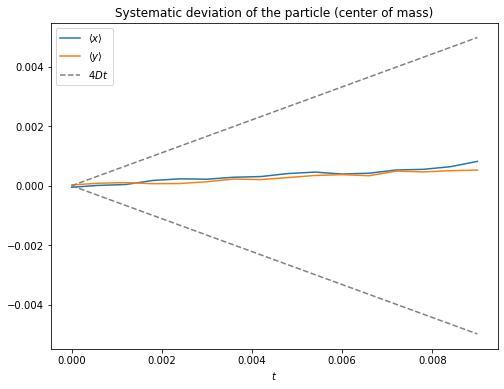

In [66]:
plt.figure(figsize=(8,6))
plt.plot(diffus_t, diffus_mass_center_x/len(diffus_R2_acc[0]), label=r"$\langle x \rangle$")
plt.plot(diffus_t, diffus_mass_center_y/len(diffus_R2_acc[0]), label=r"$\langle y \rangle$" )
plt.plot(diffus_t, +4*D*diffus_t, '--', color='grey', label=r"$4Dt$")
plt.plot(diffus_t, -4*D*diffus_t, '--', color='grey')
plt.legend()
plt.title("Systematic deviation of the particle (center of mass)")
plt.xlabel("$t$")
plt.savefig(name+"sysdev.pdf")